<a href="https://colab.research.google.com/github/BenjaminPhillips22/NLP-sentiment-analysis/blob/master/Sentiment_Analysis_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Pre-Trained Embeddings, Sentence Average

This Notebook trains a neural network to determine if a movie review is positive or negative. Pretrained work embeddings with 100 dimensions are used. The input to the network is the average of the word embeddings of the review.

In [0]:
!pip install torch
!pip install torchtext

In [0]:
import torch
from torchtext import data
from torchtext import datasets
from torchtext import vocab

import random
import numpy as np
import gensim.downloader as api

import spacy
import re

In [0]:

SEED = 1912

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, dev_data = train_data.split(random_state=random.seed(SEED))

imdb_data = {'train': train_data, 'test': test_data, 'dev': dev_data }

In [0]:
word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data


[==================================================] 100.0% 128.1/128.1MB downloaded


Some fun with word embeddings

In [0]:
word_vectors['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [0]:
word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.6311717629432678),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [0]:
word_vectors.doesnt_match("benjamin william thomas erica".split())

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'erica'

In [0]:
word_vectors.similar_by_word("cat")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dog', 0.8798074722290039),
 ('rabbit', 0.7424426674842834),
 ('cats', 0.7323004007339478),
 ('monkey', 0.7288709878921509),
 ('pet', 0.7190139889717102),
 ('dogs', 0.7163872718811035),
 ('mouse', 0.6915250420570374),
 ('puppy', 0.6800068020820618),
 ('rat', 0.6641027331352234),
 ('spider', 0.6501135230064392)]

In [0]:
word_vectors.similar_by_word("ben")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('benjamin', 0.6143866181373596),
 ('eliezer', 0.6142445802688599),
 ('eddie', 0.6124265193939209),
 ('eric', 0.6064211130142212),
 ('sam', 0.5987447500228882),
 ('alan', 0.5984522104263306),
 ('danny', 0.5886530876159668),
 ('cohen', 0.5841774940490723),
 ('adam', 0.5837752223014832),
 ('david', 0.5786920785903931)]

Now I want to make a function to take a training example and output the average of the word embeddings

In [0]:

def word_check(word, word_vectors):
    word = word.lower()
    word = re.sub(r'[^A-Za-z0-9]+', '', word) # remove non alphanumeric character
    word = re.sub(r'https?:/\/\S+', '', word) # remove links
    if word in word_vectors.vocab:
        return True, word_vectors[word]
    return False, None

In [0]:
def sentence_average(sentence, word_vectors):
    """ sentence is a list of words"""
    
    embeds = []
    for word in sentence:
        boo, woo = word_check(word, word_vectors)
        if boo:
            embeds.append(woo)
    
    # no suitable words
    if len(embeds)==0:
        return np.zeros(shape=word_vectors['a'].shape)
    return np.vstack(embeds).mean(axis=0)

In [0]:
keys = ['train', 'test', 'dev']
imdb_data_sentence_average = {}

for k in keys:
    print(k)
    data_average = []
    data_label = []
    for ex in imdb_data[k].examples:
        data_average.append(sentence_average(ex.text, word_vectors))
        if ex.label == 'pos':
            l = 1
        elif ex.label == 'neg':
            l = 0
        else:
            raise ValueError('unexpected value for label')

        data_label.append(l)
    
    imdb_data_sentence_average[k] = torch.utils.data.TensorDataset(
        torch.FloatTensor(data_average),
        torch.FloatTensor(data_label)
    )
    
        

train
test
dev


Time to make a model!!!

In [0]:
def my_auc(y, pred):
    import sklearn #.metrics.auc as auc
    y = y.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()

    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, pred)
    return sklearn.metrics.auc(fpr, tpr)


def get_dataset_auc(dataset, model):
    pred = model(dataset.tensors[0].cuda())
    labels = dataset.tensors[1]
    return my_auc(labels, pred)
    

In [0]:
BATCH_SIZE = 64
EPOCH = 51

net = torch.nn.Sequential(
        torch.nn.Linear(100, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
        torch.nn.Sigmoid()
    ).cuda()

loader = torch.utils.data.DataLoader(
    dataset=imdb_data_sentence_average['train'], 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

optimizer = torch.optim.Adam(net.parameters())
criterion = torch.nn.BCEWithLogitsLoss().cuda()

train_set_auc = []
dev_set_auc = []


for epoch in range(EPOCH):
    for step, (batch_text, batch_label) in enumerate(loader): # for each training step
        
        batch_text = batch_text.cuda()
        batch_label = batch_label.cuda()

        optimizer.zero_grad()   # clear gradients for next train
  
        prediction = net(batch_text).squeeze(1)     # input x and predict based on x

        loss = criterion(prediction, batch_label)     # must be (1. nn output, 2. target)
        
        loss.backward()         # backpropagation, compute gradients
        
        optimizer.step()        # apply gradients
        
    # every epoche, get the training data auc and dev data auc
    tsa = get_dataset_auc(imdb_data_sentence_average['train'], net)
    dsa = get_dataset_auc(imdb_data_sentence_average['dev'], net)
    print('epoch: ', str(epoch), ' trainset auc: ', round(tsa, 2), ' dev set auc: ', round(dsa, 2))
    train_set_auc.append(tsa)
    dev_set_auc.append(dsa)
    
    # save and load models
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if epoch % 10 == 0:
        torch.save(net.state_dict(), 'pretrained_embeddings_sentence_average_' + str(epoch))

epoch:  0  trainset auc:  0.85  dev set auc:  0.84
epoch:  1  trainset auc:  0.87  dev set auc:  0.86
epoch:  2  trainset auc:  0.87  dev set auc:  0.86
epoch:  3  trainset auc:  0.87  dev set auc:  0.87
epoch:  4  trainset auc:  0.88  dev set auc:  0.87
epoch:  5  trainset auc:  0.88  dev set auc:  0.87
epoch:  6  trainset auc:  0.88  dev set auc:  0.87
epoch:  7  trainset auc:  0.88  dev set auc:  0.87
epoch:  8  trainset auc:  0.89  dev set auc:  0.87
epoch:  9  trainset auc:  0.88  dev set auc:  0.87
epoch:  10  trainset auc:  0.89  dev set auc:  0.87
epoch:  11  trainset auc:  0.88  dev set auc:  0.87
epoch:  12  trainset auc:  0.89  dev set auc:  0.88
epoch:  13  trainset auc:  0.89  dev set auc:  0.88
epoch:  14  trainset auc:  0.89  dev set auc:  0.88
epoch:  15  trainset auc:  0.89  dev set auc:  0.88
epoch:  16  trainset auc:  0.89  dev set auc:  0.88
epoch:  17  trainset auc:  0.89  dev set auc:  0.88
epoch:  18  trainset auc:  0.89  dev set auc:  0.88
epoch:  19  trainset a

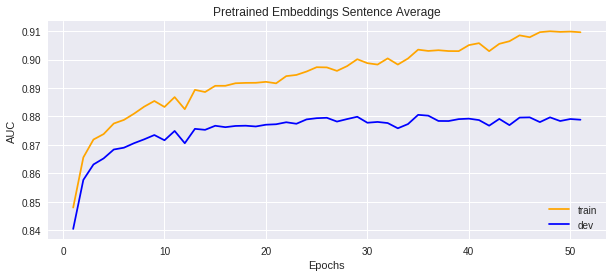

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = np.array(range(len(train_set_auc))) + 1
plt.figure(figsize=(10,4))
plt.plot(epochs, train_set_auc, color = "orange", label='train')
plt.plot(epochs, dev_set_auc, color = "blue", label='dev')
plt.legend(loc='lower right')
plt.title('Pretrained Embeddings Sentence Average')
plt.xlabel('Epochs')
plt.ylabel('AUC')
# plt.ylim((-0.05, 1.05))
plt.show()

fn = 'Pretrained Embeddings Sentence Average.png'
plt.savefig(fn)
from google.colab import files
files.download(fn) 

In [0]:

!ls

 glove.6B.100d.txt
 glove.6B.200d.txt
 glove.6B.300d.txt
 glove.6B.50d.txt
 glove.6B.zip
 pretrained_embeddings_sentence_average_0
 pretrained_embeddings_sentence_average_10
 pretrained_embeddings_sentence_average_20
 pretrained_embeddings_sentence_average_30
 pretrained_embeddings_sentence_average_40
 pretrained_embeddings_sentence_average_50
'Pretrained Embeddings Sentence Average.png'
 sample_data


How does it go on the test data?

In [0]:
net_1 = torch.nn.Sequential(
        torch.nn.Linear(100, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    ).cuda()
net_1.load_state_dict(torch.load('pretrained_embeddings_sentence_average_20'))
get_dataset_auc(imdb_data_sentence_average['test'], net_1)

0.8790636223999999